In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
sns.set(style='ticks', palette='Set2')
%matplotlib inline
import os
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

# Problem 1 - Warm up. Grid Search CV

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [3]:
digits = datasets.load_digits() ## load data

n_samples = len(digits.images)
X = digits.images.reshape((n_samples,-1)) ## value of columns is inferred
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(  ## split into 50% training and 50% test data
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision','recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,  ## build model with tuned paramemeters
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed o

# Problem 2 - Lasso, Forward Selection, and Cross Validation

In [78]:
# generate some sparse data to play with
np.random.seed(7)

n_samples, n_features = 100, 200
X = np.random.randn(n_samples, n_features)

k = 5
# beta generated with k nonzeros
coef = 10 * np.ones(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[k:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal((n_samples,))

# Split data in train set and test set
# n_samples = X.shape[0]
X_train, y_train = X[25:], y[25:]
X_test, y_test = X[:25], y[:25]

In [ ]:
X_train1, y_train1 = X[25:], y[25:]
X_test1, y_test1 = X[:25], y[:25]

OLS = LinearRegression()
OLS.fit(X_train,y_train).predict(X_test)
y_pred_OLS = OLS.fit(X_train, y_train).predict(X_test)
r2_score_OLS = r2_score(y_test, y_pred_OLS)

# 2.1

In [116]:
primary_features = []

score = 0.0
while score != 1.0: ## keep running until the R2 score is 1
    best_feature = 0
    ## get the difference between all 200 features and the chosen features so far
    for current_feature in np.setdiff1d(list(range(n_features)), primary_features).tolist(): 
        current_features = primary_features + [current_feature]
        reg = LinearRegression().fit(X_train[:, current_features], y_train)
        current_score = r2_score(y_train, reg.predict(X_train[:, current_features]))
        if current_score > score:
            best_feature, score = current_feature, current_score
    primary_features.append(best_feature)

ordered_features = primary_features + np.setdiff1d(list(range(n_features)), primary_features).tolist()
        
print('The best features which returns R2 score of 1.0: ', primary_features)
print('Order in which features were added:')
print(ordered_features)

The best features which returns R2 score of 1.0:  [18, 51, 34, 78, 15]
Order in which features were added:
[18, 51, 34, 78, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


# 2.2

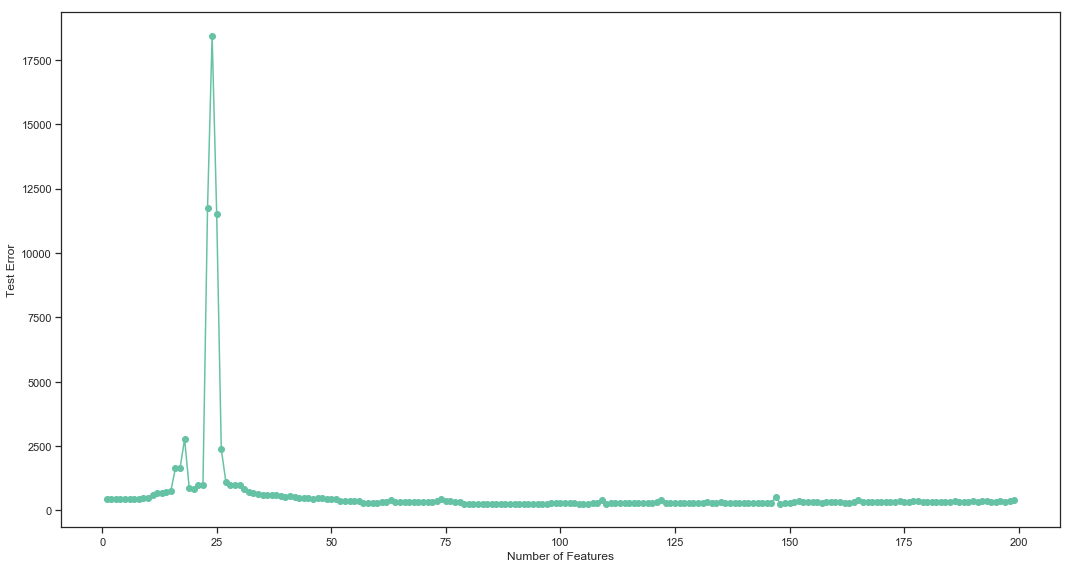

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

test_errors = np.array([])
for i in range(1,200):
    X_train, y_train = X[:25,:i], y[:25]
    X_test, y_test = X[25:,:i], y[25:]
    
    OLS = LinearRegression()
    OLS.fit(X_train,y_train).predict(X_test)
    y_pred_OLS = OLS.fit(X_train, y_train).predict(X_test)
    r2_score_OLS = r2_score(y_test, y_pred_OLS)
    #print(r2_score_OLS)
    test_error = 1 - r2_score_OLS
    #print(OLS)
    mse = metrics.mean_squared_error(y_test, y_pred_OLS) 
#     print(i)
#     print(r2_score_OLS)
    test_errors=np.append(test_errors,mse)
    #print("Test Error is : %f" % test_error)
fig=plt.subplots(figsize=(15,8))
plt.plot(range(1, 200), test_errors, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Test Error')
plt.tight_layout()
plt.show()

# 2.3

Source: "http://scikit-learn.sourceforge.net/stable/modules/generated/sklearn.grid_search.GridSearchCV.html"

Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” method and a “predict” method like any classifier except that the parameters of the classifier used to predict is optimized by cross-validation.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

# lasso regression has constraints on the size of the coefficients being used
# so necessary to standardize the variables
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)

# specify some parameter values
param_grid = [
    {'alpha':[1.0,0.0,0.1,0.01,0.001]}
]

In [7]:
model = Lasso() # use Lasso model 
lasso_grid = GridSearchCV(model, param_grid, cv=5) 
lasso_grid

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [1.0, 0.0, 0.1, 0.01, 0.001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [9]:
lasso_grid.fit(X_train_std, y_train)
lasso_grid.best_estimator_ # get the best alpha value for cv = 5

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

# 2.4

In [10]:
cv = [2,10,15,25] # test for some different values of CV
for i in cv:
    lasso_grid = GridSearchCV(model, param_grid, cv=i)
    lasso_grid.fit(X_train_std, y_train)
    print("cv: " + str(i))
    print(lasso_grid.best_estimator_)

cv: 2
Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
cv: 10
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
cv: 15
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
cv: 25
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


As the number of folds in the CV increases, the optimal value of the hyperparameter becomes closer to 1.0

# 2.5

In [11]:
max_iter = 1000
cv = 5
reg = LassoCV(max_iter=max_iter, cv=cv)
print('Implementing LassoCV with {} iter. and {}-fold CV'.format(max_iter, cv))
lassocv = reg.fit(X_train_std, y_train)
print('LassoCV alpha = {}'.format(lassocv.alpha_))

Implementing LassoCV with 1000 iter. and 5-fold CV
LassoCV alpha = 2.018316500014024


In [12]:
cv = [2,5,10,15,25] # test for some different values of CV
max_iter = 1000
for i in cv:
    regres = LassoCV(max_iter=max_iter, cv=i, copy_X=False, n_jobs=1)
    print('Implementing LassoCV with {} iter. and {}-fold CV'.format(max_iter, i))
    lassocv = regres.fit(X_train_std, y_train)
    print('LassoCV alpha = {}'.format(lassocv.alpha_))

Implementing LassoCV with 1000 iter. and 2-fold CV
LassoCV alpha = 4.055268121449756
Implementing LassoCV with 1000 iter. and 5-fold CV
LassoCV alpha = 2.018316500014024
Implementing LassoCV with 1000 iter. and 10-fold CV
LassoCV alpha = 0.6609076605543233
Implementing LassoCV with 1000 iter. and 15-fold CV
LassoCV alpha = 0.05360825797806968
Implementing LassoCV with 1000 iter. and 25-fold CV
LassoCV alpha = 0.24882749162044132


The optimal value of the hyperparameter behaves very differently when LassoCV is used vs. GridSearchCV. GridSearch has some specified parameter values that we give to the model but LassoCV computes and returns the optimal trained alpha/hyperparameter value.

# Problem 3 - A Mathematical Theory of Communication

    To begin with, I learned about the design of Shannon’s structure of a general communication system. The structure starts with an information source that produces a message which can be a sequence of letters or a function(s) of time. The message is sent to a transmitter which does a telephonic or telegraphic operation, depending on the nature of the message, to generate a signal that can be used transmit the message over a channel. A channel in this structure can be wires, a cable, a beam of light, or anything that can be used to send a signal from the transmitter to a receiver. The structure thus also consists of a receiver and a destination. The receiver performs the opposite of the operation done by the transmitter to obtain a message from the signal and the destination is the counterpart to the information source. Moreover, there are various types of communication systems: discrete, continuous, and mixed. In particular, I learned how there can be a mixed system in which both discrete and continuous variables appear. An example is Pulse Code Modulation, where a signal is pulse code modulated to convert its analog information, represented by continuous variables, into a binary (discrete) sequence.

    Furthermore, in the case of discrete systems, I learned how there are some interesting and increasingly complex ways of generating the sequence of letters which forms the initial message. The simplest method is to take some letters, assign them independent probabilities, and create a message analogous to one long word by using the probabilities of those letters occurring for each symbol or letter in the sequence. Another way would be to take into account the preceding symbol when defining the probabilities of successive symbols being chosen. In this case, the constructed message would be less random than before and contain more visible patterns of symbols within the sequence, given the probabilities of a particular symbol appearing after another. The final level of complexity would be to use the preceding two symbols to determine the probabilities and then generate the sequence. The same three ways can be applied to whole words instead of letters to create a message analogous to a sentence. Words, in this instance, are just a group of random letters. These processes have intriguing results when applied to the English language and to its entire alphabet. Shannon shows how the methods of generating the message, from zero-order to second-word approximation i.e. from independent probabilities for each symbol to using the preceding two letters and/or words to determine the probabilities of successive letters/words, results in the message looking more and more like natural English text. Also, there is a group among the discrete processes called the "ergodic" processes where every sequence is statistically the same. All of the aforementioned processes can be said to be ergodic because they produce sequences which have the same statistical properties. 

# Problem 4

In [ ]:
pip install tabula-py

In [ ]:
pip install -U selenium

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Scrape the files from the url into your local machine
# Execute only once. This scrapes the website and copies the pdf files to your local machine
import os
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup

url = "http://proceedings.mlr.press/v97/"

#If there is no such folder, the script will create one automatically
folder_location = r'C:\Fall - BDS\HW 4\pdfiles'
if not os.path.exists(folder_location):os.mkdir(folder_location)

response = requests.get(url)
soup= BeautifulSoup(response.text, "html.parser")     
for link in soup.select("a[href$='.pdf']"):
    #Name the pdf files using the last portion of each link which are unique in this case
    filename = os.path.join(folder_location,link['href'].split('/')[-1])
    with open(filename, 'wb') as f:
        f.write(requests.get(urljoin(url,link['href'])).content)

In [ ]:
# Create a text file on our local machine, in this case : testing.txt
# Read all the pdf files and write its contents to the text file.
# Execute only once.
import glob
from tika import parser

path =r'C:\Fall - BDS\HW 4\pdfiles'
all_files = glob.glob(path + "/*.pdf")
i = 1
with open('testing.txt', 'a', encoding='utf-8') as file:
    for filename in all_files:
        try:
            print("Reading file:")
            print(filename)
            i=i+1
            raw = parser.from_file(filename)
            text = raw['content']
        # text = text.replace('\n\n', '\n')
            text = text.strip('\n')
            text = text.replace('\n','')
            text = text.replace('\t','')
        #with open('testing.txt', 'a', encoding='utf-8') as file:
            file.write(text)
        except:
            #print(i)
            pass
file.close()

# 4.1 Top 10 Common Words

Assumption : Stop words have been counted as part of the common words.

In [13]:
# get the count of 10 most frequent words.
from collections import Counter

file = open('testing.txt', "r", encoding="utf-8-sig")
wordcount={}
for word in file.read().split():
    if word not in wordcount:
        wordcount[word] = 1
    else:
        wordcount[word] += 1
#for k,v in wordcount.items():
    #print(k, v)
file.close()
word_frequency = Counter(wordcount)
word_frequency.most_common(10)

[('the', 317958),
 ('of', 176607),
 ('and', 151282),
 ('to', 104445),
 ('a', 100178),
 ('is', 91942),
 ('in', 88688),
 ('for', 74951),
 ('=', 71116),
 ('we', 60425)]

# 4.2

In [16]:
# randomly select a file and then a word in that file. Lets call it Z. Calculate the entropy of Z.
import random
import nltk
import glob
files=[]
path =r'C:\Fall - BDS\HW 4\pdfiles'
all_files = glob.glob(path + "/*.pdf")
for file in all_files:
    files.append(file)
random_file = random.choice(files)
file_name = random_file[(random_file.rfind('\\')+1):len(random_file)]
print("Randomly selecting file:",file_name)

Randomly selecting file: haviv19a.pdf


In [21]:
# read the pdf contents into text, tokenize the sentences and then randomly choose any one word
from tika import parser
raw = parser.from_file(random_file)
text = raw['content']
# text = text.replace('\n\n', '\n')
text = text.strip('\n')
text = text.replace('\n','')
text = text.replace('\t','')
# text
#tokenize the string
tokens = nltk.word_tokenize(text.lower())
#randomly select a word
random_token = random.choice(tokens)
random_token

'that'

In [22]:
freqList=[]
ctr = 0
for word in tokens:    
    if word == random_token:
            ctr += 1
#freq = (float(ctr) / len(tokens))
freqList.append(float(ctr) / len(tokens))
# Shannon entropy
import math
ent = 0.0
for freq in freqList:
    ent = ent + freq * math.log(freq, 2)
ent = -ent
print('The entropy  of the randomly chosen word: ' + random_token + " from the randomly chosen file: " + file_name + " is :")
print(ent)

The entropy  of the randomly chosen word: that from the randomly chosen file: haviv19a.pdf is :
0.05915035299384212


## 4.3

In [56]:
#Synthesize a random paragraph
#Assumption : Word frequency is used instead of marginal probability.
# 500 words were chosen to form the paragraph.

In [23]:
paragraph = ''
common_words = word_frequency.most_common(500)
for words in common_words:
    paragraph = paragraph + ' ' + (words[0])
paragraph

' the of and to a is in for = we that with on et as . by + are be al., − In The can this from ∈ , an We which ≤ 1 our at all it each not & have learning model set · using 2 where For function such data A if use any has 0 or also training two pp. This number ≥ al. over > algorithm � then one only when used first A., more between 1, than results J. J., distribution its A. different bound show these will gradient neural same Conference M., Learning loss S., given following but other : both some M. models ) probability random k T 1. < problem there matrix X S. Let 3 method log linear Theorem policy network methods i Neural time value performance deep Figure x their D. International | optimal f Lemma size into test n case Section based error R. F 4 consider via D., t was defined 0, under networks approach input P N parameters rate work := while so sample may large optimization vector samples algorithms point space Machine standard most Proceedings state been Algorithm proposed → new does P.

# Problem 5

In [24]:
df_arsenic = pd.read_csv('wells.dat', sep=' ')

# 5.1

In [26]:
X = df_arsenic.loc[:,["dist"]].values # only include one feature - distance
y = df_arsenic.loc[:,["switch"]].values
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=1) 

In [27]:
# run logistic regression
LR = LogisticRegression(fit_intercept = True, random_state=0)
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

In [29]:
# get coefficient for distance feature
beta = LR.coef_[0][0]
beta

-0.006180340755753423

In [30]:
intercept = LR.intercept_[0]
intercept

0.5964069608465984

# 5.2

In [31]:
# define logistic function using the coefficient and intercept gathered from regression
x = X_test
t = beta*x + intercept
y = 1/(1+np.exp(-t))

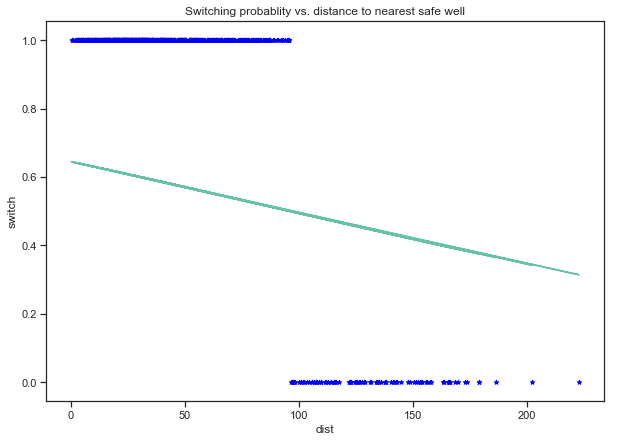

In [32]:
fig = plt.figure(figsize=(10,7))
plt.scatter(x = X_test, y = y_pred, s = 20, marker='*', c='blue',)
plt.plot(x, y)
plt.xlabel("dist")
plt.ylabel("switch")
plt.title("Switching probablity vs. distance to nearest safe well")
plt.show()

# 5.3

In [33]:
print((beta/4)*100)

-0.15450851889383557


According to the "rule of four," for every increase of 100 meters of distance to the nearest well, the probability of switching wells will decrease by approximately 15.5%

# 5.4

In [34]:
# change x to the distance and arsenic features
X_new = df_arsenic.loc[:,["arsenic","dist"]].values
y = df_arsenic.loc[:,["switch"]].values

In [35]:
# split test train data and run regression
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = .3, random_state=0)
LR_2 = LogisticRegression(fit_intercept = True, random_state=0)
LR_2.fit(X_train,y_train)
y_pred = LR_2.predict(X_test)

In [36]:
LR_2.coef_ ## dist, arsenic coefficients

array([[ 0.42792299, -0.00943456]])

## The coefficents are -0.00943456 for distance and 0.42792299 for arsenic levels

# 5.5

In [37]:
# standardize the two features
sc = StandardScaler()
sc.fit(X_new)
X_std = sc.transform(X_new)

In [38]:
# run regression on the standardized x
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = .3, random_state=0)
LR = LogisticRegression(fit_intercept = True, random_state=0)
LR.fit(X_train,y_train)
LR.coef_

array([[ 0.47314458, -0.36209611]])

## After standardizing both the features, the coefficient is 0.473 for arsenic and -0.362 for distance. Thus, the level of arsenic is a more significant factor than distance

## 5.6

In [39]:
# use all features
X_all = df_arsenic.loc[:,["arsenic","dist","assoc","educ"]].values
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = .3, random_state=1)
clf = LogisticRegressionCV(cv=10, random_state=0, multi_class='multinomial').fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(1-score)

0.3984547461368654


In [40]:
# add interaction terms for arsenic
X_arsenic_assoc = df_arsenic["arsenic"]*df_arsenic["assoc"]
df_arsenic["arsenic_assoc"] = X_arsenic_assoc

X_arsenic_dist = df_arsenic["arsenic"]*df_arsenic["dist"]
df_arsenic["arsenic_dist"] = X_arsenic_dist

X_arsenic_educ = df_arsenic["arsenic"]*df_arsenic["educ"]
df_arsenic["arsenic_educ"] = X_arsenic_educ

# add interaction terms 
X_dist_assoc = df_arsenic["dist"]*df_arsenic["assoc"]
df_arsenic["dist_assoc"] = X_dist_assoc

X_dist_educ = df_arsenic["dist"]*df_arsenic["educ"]
df_arsenic["dist_educ"] = X_dist_educ

X_assoc_educ = df_arsenic["assoc"]*df_arsenic["educ"]
df_arsenic["assoc_educ"] = X_assoc_educ

In [41]:
interactionList = []
interactionList = ["arsenic_educ", "arsenic_assoc", "arsenic_dist", "dist_assoc", "dist_educ", "assoc_educ"]
size = len(interactionList)

In [42]:
features = ["arsenic","dist","assoc","educ"]

In [43]:
from itertools import combinations 

scores = []
for i in range(1,size):
    
    comb = combinations(interactionList,i) # get all combinations of the interaction terms of length i
  
    # loop over the obtained combinations of interaction terms
    for j in list(comb): 
        print("interaction terms: " + str(j))
        interactions = list(j) # convert from tuple to list
        X_all = df_arsenic.loc[:,features+interactions].values # add the features to the interaction terms
        
        # split data and run regression
        X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = .3, random_state=1)
        clf = LogisticRegressionCV(cv=10, random_state=0, multi_class='multinomial').fit(X_train, y_train)
        
        # get accuracy for test data
        score = clf.score(X_test, y_test)
        
        # test error
        print(1-score)
        scores.append(1-score)

interaction terms: ('arsenic_educ',)
0.3841059602649006
interaction terms: ('arsenic_assoc',)
0.39514348785871967
interaction terms: ('arsenic_dist',)
0.3973509933774835
interaction terms: ('dist_assoc',)
0.4028697571743929
interaction terms: ('dist_educ',)
0.39403973509933776
interaction terms: ('assoc_educ',)
0.4017660044150111
interaction terms: ('arsenic_educ', 'arsenic_assoc')
0.38520971302428253
interaction terms: ('arsenic_educ', 'arsenic_dist')
0.38631346578366443
interaction terms: ('arsenic_educ', 'dist_assoc')
0.38852097130242824
interaction terms: ('arsenic_educ', 'dist_educ')
0.3785871964679912
interaction terms: ('arsenic_educ', 'assoc_educ')
0.38631346578366443
interaction terms: ('arsenic_assoc', 'arsenic_dist')
0.39293598233995586
interaction terms: ('arsenic_assoc', 'dist_assoc')
0.3984547461368654
interaction terms: ('arsenic_assoc', 'dist_educ')
0.3841059602649006
interaction terms: ('arsenic_assoc', 'assoc_educ')
0.4006622516556292
interaction terms: ('arsenic_dist

In [44]:
min(scores)

0.3719646799116998

### The test error of the best model is 0.3719646799116998

# THE END